In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


In [3]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [4]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, rates, training

In [5]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [6]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [7]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates, training):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size, training=training)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states, training=training)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, training=training, 
                        reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [8]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [9]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rates=self.rates, training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [10]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [11]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [12]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [13]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [14]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*2):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                                          model.training: False})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states, 
                                                                   model.training: False})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA], #, model.d_optQ
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates, 
                                                                   model.training: True})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:1.3518 dlossA:1.4642 dlossQ:2.0211 exploreP:0.9979
Episode:1 meanR:19.0000 R:17.0000 rate:0.0340 gloss:1.2405 dlossA:1.4596 dlossQ:1.9713 exploreP:0.9962
Episode:2 meanR:27.6667 R:45.0000 rate:0.0900 gloss:1.1569 dlossA:1.4565 dlossQ:1.6681 exploreP:0.9918
Episode:3 meanR:28.2500 R:30.0000 rate:0.0600 gloss:1.0291 dlossA:1.4485 dlossQ:1.6359 exploreP:0.9889
Episode:4 meanR:25.0000 R:12.0000 rate:0.0240 gloss:0.9760 dlossA:1.4436 dlossQ:1.4303 exploreP:0.9877
Episode:5 meanR:23.8333 R:18.0000 rate:0.0360 gloss:0.8847 dlossA:1.4416 dlossQ:1.3957 exploreP:0.9859
Episode:6 meanR:22.8571 R:17.0000 rate:0.0340 gloss:0.9474 dlossA:1.4402 dlossQ:1.4581 exploreP:0.9843
Episode:7 meanR:28.1250 R:65.0000 rate:0.1300 gloss:0.8795 dlossA:1.4310 dlossQ:1.5557 exploreP:0.9780
Episode:8 meanR:27.8889 R:26.0000 rate:0.0520 gloss:0.9567 dlossA:1.4243 dlossQ:2.2090 exploreP:0.9755
Episode:9 meanR:27.0000 R:19.0000 rate:0.0380 gloss:0.8973 dlossA:1.4220 

Episode:79 meanR:23.6500 R:16.0000 rate:0.0320 gloss:0.3087 dlossA:1.3095 dlossQ:2.1324 exploreP:0.8293
Episode:80 meanR:23.5556 R:16.0000 rate:0.0320 gloss:0.2683 dlossA:1.3054 dlossQ:1.9284 exploreP:0.8280
Episode:81 meanR:23.5244 R:21.0000 rate:0.0420 gloss:0.2424 dlossA:1.3000 dlossQ:1.6620 exploreP:0.8263
Episode:82 meanR:23.8554 R:51.0000 rate:0.1020 gloss:0.2690 dlossA:1.3087 dlossQ:2.1309 exploreP:0.8222
Episode:83 meanR:24.0833 R:43.0000 rate:0.0860 gloss:0.3101 dlossA:1.3092 dlossQ:2.4030 exploreP:0.8187
Episode:84 meanR:24.1294 R:28.0000 rate:0.0560 gloss:0.2104 dlossA:1.2944 dlossQ:1.8272 exploreP:0.8164
Episode:85 meanR:24.5349 R:59.0000 rate:0.1180 gloss:0.3044 dlossA:1.3085 dlossQ:2.4987 exploreP:0.8117
Episode:86 meanR:24.3563 R:9.0000 rate:0.0180 gloss:0.3214 dlossA:1.3062 dlossQ:2.2390 exploreP:0.8110
Episode:87 meanR:24.3295 R:22.0000 rate:0.0440 gloss:0.3081 dlossA:1.3052 dlossQ:2.3416 exploreP:0.8092
Episode:88 meanR:24.2360 R:16.0000 rate:0.0320 gloss:0.2986 dloss

Episode:158 meanR:26.5000 R:12.0000 rate:0.0240 gloss:0.0787 dlossA:1.2575 dlossQ:1.7777 exploreP:0.6732
Episode:159 meanR:26.5700 R:22.0000 rate:0.0440 gloss:0.1804 dlossA:1.2706 dlossQ:2.1742 exploreP:0.6717
Episode:160 meanR:26.4900 R:55.0000 rate:0.1100 gloss:0.1509 dlossA:1.2714 dlossQ:2.3556 exploreP:0.6681
Episode:161 meanR:26.5100 R:18.0000 rate:0.0360 gloss:0.2472 dlossA:1.2880 dlossQ:3.1892 exploreP:0.6669
Episode:162 meanR:26.5000 R:22.0000 rate:0.0440 gloss:0.1487 dlossA:1.2740 dlossQ:2.1205 exploreP:0.6654
Episode:163 meanR:26.6600 R:32.0000 rate:0.0640 gloss:0.2217 dlossA:1.2871 dlossQ:2.8654 exploreP:0.6633
Episode:164 meanR:26.7900 R:46.0000 rate:0.0920 gloss:0.1565 dlossA:1.2730 dlossQ:2.3195 exploreP:0.6603
Episode:165 meanR:26.8500 R:25.0000 rate:0.0500 gloss:0.1619 dlossA:1.2706 dlossQ:2.1305 exploreP:0.6587
Episode:166 meanR:26.7100 R:11.0000 rate:0.0220 gloss:0.1258 dlossA:1.2641 dlossQ:2.1169 exploreP:0.6580
Episode:167 meanR:26.9000 R:33.0000 rate:0.0660 gloss:0

Episode:237 meanR:26.7100 R:12.0000 rate:0.0240 gloss:0.0227 dlossA:1.2378 dlossQ:1.7593 exploreP:0.5434
Episode:238 meanR:26.7500 R:20.0000 rate:0.0400 gloss:0.1812 dlossA:1.2713 dlossQ:2.3881 exploreP:0.5424
Episode:239 meanR:26.7100 R:19.0000 rate:0.0380 gloss:0.2599 dlossA:1.2955 dlossQ:3.0664 exploreP:0.5413
Episode:240 meanR:26.9000 R:44.0000 rate:0.0880 gloss:0.1330 dlossA:1.2694 dlossQ:2.3501 exploreP:0.5390
Episode:241 meanR:26.8700 R:24.0000 rate:0.0480 gloss:0.0530 dlossA:1.2474 dlossQ:1.6736 exploreP:0.5377
Episode:242 meanR:26.9000 R:14.0000 rate:0.0280 gloss:0.1442 dlossA:1.2679 dlossQ:2.2948 exploreP:0.5370
Episode:243 meanR:26.8800 R:19.0000 rate:0.0380 gloss:0.1341 dlossA:1.2570 dlossQ:2.1011 exploreP:0.5360
Episode:244 meanR:26.7500 R:13.0000 rate:0.0260 gloss:0.3869 dlossA:1.3061 dlossQ:4.7197 exploreP:0.5353
Episode:245 meanR:26.6300 R:18.0000 rate:0.0360 gloss:0.2051 dlossA:1.2877 dlossQ:2.3618 exploreP:0.5344
Episode:246 meanR:26.6600 R:28.0000 rate:0.0560 gloss:0

Episode:316 meanR:29.1000 R:18.0000 rate:0.0360 gloss:0.2195 dlossA:1.2756 dlossQ:2.3612 exploreP:0.4338
Episode:317 meanR:29.4200 R:45.0000 rate:0.0900 gloss:0.1626 dlossA:1.2673 dlossQ:2.1153 exploreP:0.4319
Episode:318 meanR:29.4700 R:26.0000 rate:0.0520 gloss:0.1487 dlossA:1.2709 dlossQ:2.6086 exploreP:0.4308
Episode:319 meanR:29.3700 R:16.0000 rate:0.0320 gloss:0.1564 dlossA:1.2718 dlossQ:2.1865 exploreP:0.4301
Episode:320 meanR:29.1700 R:21.0000 rate:0.0420 gloss:0.2789 dlossA:1.2990 dlossQ:3.2015 exploreP:0.4293
Episode:321 meanR:29.3800 R:47.0000 rate:0.0940 gloss:0.1295 dlossA:1.2666 dlossQ:2.1155 exploreP:0.4273
Episode:322 meanR:29.4400 R:26.0000 rate:0.0520 gloss:0.2459 dlossA:1.2805 dlossQ:3.1116 exploreP:0.4262
Episode:323 meanR:29.2400 R:26.0000 rate:0.0520 gloss:0.2405 dlossA:1.2865 dlossQ:3.0392 exploreP:0.4251
Episode:324 meanR:29.1600 R:22.0000 rate:0.0440 gloss:0.1807 dlossA:1.2765 dlossQ:2.3107 exploreP:0.4242
Episode:325 meanR:29.3400 R:60.0000 rate:0.1200 gloss:0

Episode:394 meanR:77.0400 R:405.0000 rate:0.8100 gloss:0.1480 dlossA:1.2839 dlossQ:2.4042 exploreP:0.2179
Episode:395 meanR:80.7800 R:389.0000 rate:0.7780 gloss:0.1782 dlossA:1.2867 dlossQ:2.6665 exploreP:0.2100
Episode:396 meanR:84.7200 R:409.0000 rate:0.8180 gloss:0.1903 dlossA:1.2849 dlossQ:2.9064 exploreP:0.2020
Episode:397 meanR:87.6900 R:341.0000 rate:0.6820 gloss:0.1615 dlossA:1.2859 dlossQ:2.8829 exploreP:0.1955
Episode:398 meanR:87.6400 R:41.0000 rate:0.0820 gloss:0.0946 dlossA:1.2997 dlossQ:1.7335 exploreP:0.1948
Episode:399 meanR:87.5400 R:44.0000 rate:0.0880 gloss:0.2234 dlossA:1.2936 dlossQ:2.6721 exploreP:0.1940
Episode:400 meanR:92.3800 R:500.0000 rate:1.0000 gloss:0.2030 dlossA:1.2936 dlossQ:2.7933 exploreP:0.1850
Episode:401 meanR:97.2400 R:500.0000 rate:1.0000 gloss:0.2231 dlossA:1.3054 dlossQ:2.7435 exploreP:0.1765
Episode:402 meanR:101.8200 R:500.0000 rate:1.0000 gloss:0.1945 dlossA:1.2974 dlossQ:2.4751 exploreP:0.1683
Episode:403 meanR:106.3200 R:500.0000 rate:1.00

Episode:471 meanR:338.7900 R:482.0000 rate:0.9640 gloss:0.5311 dlossA:1.3511 dlossQ:3.0160 exploreP:0.0207
Episode:472 meanR:339.2700 R:168.0000 rate:0.3360 gloss:0.5195 dlossA:1.3539 dlossQ:3.2370 exploreP:0.0205
Episode:473 meanR:340.1800 R:209.0000 rate:0.4180 gloss:0.5087 dlossA:1.3488 dlossQ:2.6502 exploreP:0.0203
Episode:474 meanR:342.0900 R:243.0000 rate:0.4860 gloss:0.5200 dlossA:1.3477 dlossQ:2.6084 exploreP:0.0201
Episode:475 meanR:345.7300 R:406.0000 rate:0.8120 gloss:0.5343 dlossA:1.3530 dlossQ:2.9041 exploreP:0.0197
Episode:476 meanR:347.7300 R:295.0000 rate:0.5900 gloss:0.5141 dlossA:1.3470 dlossQ:2.8223 exploreP:0.0194
Episode:477 meanR:352.0800 R:500.0000 rate:1.0000 gloss:0.5134 dlossA:1.3543 dlossQ:2.4850 exploreP:0.0189
Episode:478 meanR:354.2400 R:381.0000 rate:0.7620 gloss:0.5104 dlossA:1.3476 dlossQ:2.9478 exploreP:0.0186
Episode:479 meanR:353.5300 R:260.0000 rate:0.5200 gloss:0.5355 dlossA:1.3492 dlossQ:3.1442 exploreP:0.0184
Episode:480 meanR:356.5700 R:500.0000

Episode:548 meanR:397.0600 R:500.0000 rate:1.0000 gloss:0.8377 dlossA:1.0766 dlossQ:3.5500 exploreP:0.0104
Episode:549 meanR:394.5000 R:244.0000 rate:0.4880 gloss:0.8471 dlossA:1.1011 dlossQ:3.2549 exploreP:0.0104
Episode:550 meanR:394.5000 R:500.0000 rate:1.0000 gloss:0.8384 dlossA:1.0459 dlossQ:3.3313 exploreP:0.0104
Episode:551 meanR:394.0200 R:434.0000 rate:0.8680 gloss:0.8821 dlossA:1.0585 dlossQ:3.8296 exploreP:0.0104
Episode:552 meanR:396.1400 R:500.0000 rate:1.0000 gloss:0.8756 dlossA:1.0710 dlossQ:3.7087 exploreP:0.0104
Episode:553 meanR:397.7900 R:500.0000 rate:1.0000 gloss:0.8824 dlossA:1.0712 dlossQ:3.5698 exploreP:0.0103
Episode:554 meanR:399.7800 R:500.0000 rate:1.0000 gloss:0.8914 dlossA:1.1008 dlossQ:3.5211 exploreP:0.0103
Episode:555 meanR:402.5100 R:500.0000 rate:1.0000 gloss:0.8432 dlossA:1.0266 dlossQ:3.1866 exploreP:0.0103
Episode:556 meanR:403.4600 R:273.0000 rate:0.5460 gloss:0.9239 dlossA:1.0660 dlossQ:3.7966 exploreP:0.0103
Episode:557 meanR:404.1700 R:239.0000

Episode:625 meanR:430.1200 R:500.0000 rate:1.0000 gloss:1.3088 dlossA:0.2524 dlossQ:10.1000 exploreP:0.0100
Episode:626 meanR:430.9800 R:330.0000 rate:0.6600 gloss:1.3433 dlossA:0.2361 dlossQ:10.5144 exploreP:0.0100
Episode:627 meanR:428.6800 R:270.0000 rate:0.5400 gloss:1.3877 dlossA:0.2276 dlossQ:11.6516 exploreP:0.0100
Episode:628 meanR:428.8000 R:315.0000 rate:0.6300 gloss:1.3676 dlossA:0.2417 dlossQ:11.0366 exploreP:0.0100
Episode:629 meanR:430.7800 R:500.0000 rate:1.0000 gloss:1.3494 dlossA:0.2269 dlossQ:11.3331 exploreP:0.0100
Episode:630 meanR:433.0200 R:500.0000 rate:1.0000 gloss:1.4037 dlossA:0.2095 dlossQ:12.0254 exploreP:0.0100
Episode:631 meanR:430.8700 R:285.0000 rate:0.5700 gloss:1.3573 dlossA:0.1906 dlossQ:11.6644 exploreP:0.0100
Episode:632 meanR:428.4500 R:258.0000 rate:0.5160 gloss:1.3868 dlossA:0.1697 dlossQ:12.4473 exploreP:0.0100
Episode:633 meanR:428.8800 R:368.0000 rate:0.7360 gloss:1.4552 dlossA:0.1877 dlossQ:13.1932 exploreP:0.0100
Episode:634 meanR:428.8800 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

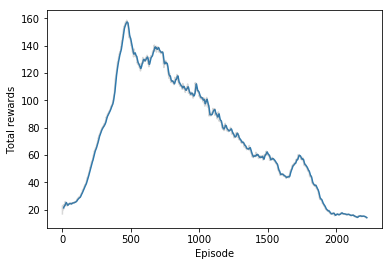

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

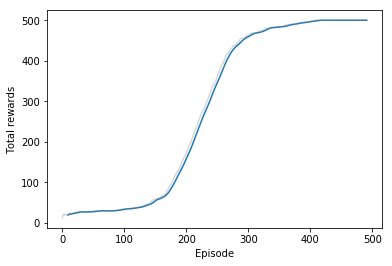

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

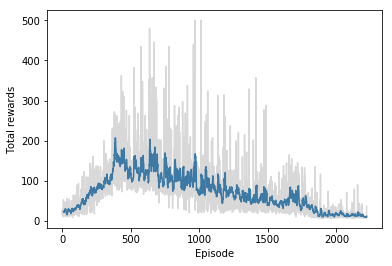

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

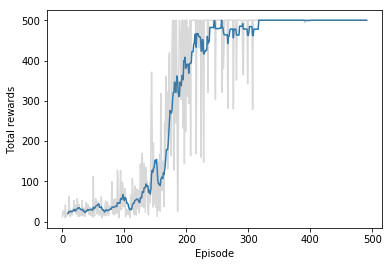

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.